# Books Recommendations using SVD vs SVD Func

In [1]:
# !pip install scikit-surprise

# Import Dependencies

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from surprise import accuracy, Dataset, Reader, SVD, BaselineOnly, PredictionImpossible
from surprise.model_selection import train_test_split, cross_validate, KFold, GridSearchCV
import random
import numpy as np
import statistics as st
from scipy.sparse.linalg import svds
import math 
import pickle

In [112]:
def binning(bins_start, df, col_name, bin_col_name):
    # bins_start is a list with start points of ranges for binning, e.g. bins_start=[0,25,50,100,300]
    # df - dataframe with data to bin
    # col_name - name of a column in df to bin
    # bin_col_name - name of newly created column for labels with bin identificator
    bins = bins_start + [float('inf')] #the last bin going to infinity
    # create labels for the bins
    bins_labels = [f'({bins_start[i]}-{bins_start[i+1]}]' for i in range(len(bins_start)-1)]
    bins_labels.append(f'>{bins_start[-1]}')
    # bin the data
    df[bin_col_name] = pd.cut(df[col_name], bins=bins, labels=bins_labels, include_lowest=True)
    return df

In [3]:
# define a formula for calculation of average weighted score
def average_weighted(row):
    min_th=25 #min number of rating received by the book
    neutral_score=5
    avg_w = ((row['avg_book_rating'] * row['count_book_rating']) + 
      (min_th * neutral_score))/(row['count_book_rating'] + min_th)
    return avg_w

In [4]:
# having min_books_rated_by_user and min_rates_received_by_book to define what we treat as statistically significant
# remove those records from ratings_df, which have those books with less than min_rates_received_by_book reviews and those users who have left less than min_books_rated_by_user reviews
def leave_stat_sign_data(ratings_df, min_books_rated_by_user=5,min_rates_received_by_book=5):
    #select only those books which were rated more than min_rates_received_by_book
    groupped_r_books=ratings_df.groupby('Book-Title')['User-ID'].count()
    titles_with_acceptable_rates_count=list(groupped_r_books[groupped_r_books>min_rates_received_by_book].index)
    #select only those users (user_id) who rated more than min_books_rated_by_user books
    groupped_r_users=ratings_df.groupby('User-ID')['Book-Rating'].count()
    user_ids_with_acceptable_books_count_rated=list(groupped_r_users[groupped_r_users>min_books_rated_by_user].index)
    # filter rating-user data to have only books/users of interest (which have highest rates count and rated highest number of books respectively)
    rating_final_df=ratings_df[ratings_df['Book-Title'].isin(titles_with_acceptable_rates_count)&ratings_df['User-ID'].isin(user_ids_with_acceptable_books_count_rated)]
    return rating_final_df

In [5]:
# define formula for calculation of rmse, having actual and predicted rates lists
def rmse(actual_rates, predicted_rates):
    error = actual_rates - predicted_rates
    mean_square_error=sum([i*i for i in error])/len(error)
    return math.sqrt(mean_square_error)

In [6]:
# split data in such a ways that we have data for all the users in both train and test sets - to be used by pure SVD
def train_test_split_SVD (rating_final_df, test_ratio = 0.1):
    user_list = rating_final_df['User-ID'].unique() #list of all users
    test_set = pd.DataFrame(columns=rating_final_df.columns) # reserve df for a train set
    train_set = pd.DataFrame(columns=rating_final_df.columns) # reserve df for a test set
    for user in user_list:
        # for each user take their book/rating data 
        user_data_all = rating_final_df[rating_final_df['User-ID'] == user]
        n = len(user_data_all)
        user_data_all = user_data_all.reset_index()
        user_data_all.drop('index', axis=1, inplace=True)
        # split user data into train and test 
        test_size = int(test_ratio*n)

        # randomly select roughtly 10% of rows for test set per user using random_state=1, so that result is reproducible
        test = user_data_all.sample(n=test_size, random_state=1)  

        # rows not selected for test set, assigned to train one
        train = user_data_all.drop(test.index)

        test_set = pd.concat([test_set, test], ignore_index=True)
        train_set = pd.concat([train_set, train], ignore_index=True)
    return (train_set, test_set)

In [7]:
# prepare data for parsing by 'surprise algorithms' and split into train and test sets, having test part 'test_prop' out of all data
def data_prep_train_test_split_surpsise(rating_final_df, rating_min=1, rating_max=10, test_prop=0.1):
    # Even having dataframe we need to create a 'reader' with the 'rating_scale' parameter to let know that our dataset has ratings from 1 to 10
    # https://surprise.readthedocs.io/en/stable/getting_started.html#load-custom
    reader = Reader(rating_scale=(rating_min,rating_max))
    # and create respective surprise.dataset object, so that our data are in a proper format for the recommendation algorithms
    data_surprise_o = Dataset.load_from_df(rating_final_df[['User-ID','Book-Title','Book-Rating']], reader)
    # Split our data into train and test, using random_state = 42 so that we receive reproducable output
    random_state = 42
    # Reference: https://surprise.readthedocs.io/en/stable/getting_started.html?highlight=train_test_split#train-test-split-and-the-fit-method
    train_set, test_set = train_test_split(data_surprise_o, test_size=test_prop, shuffle=True, random_state=random_state)
    return (data_surprise_o, train_set, test_set)

In [8]:
# test the performance over a different number of laatent factors k_set
def test_rmse_SVD(train_set, test_set, k_set = [8, 20, 50, 100, 150]):
    rmse_scores={}
    over_mean=train_set['Book-Rating'].mean()
    for l_f in k_set: 
        # Build the prediction matrix using the train_set
        all_predictions_df = build_prediction_matrix_SVD(train_set, l_f)

        # reserve a list for predicted ratings
        pred = []
        for i, row in test_set.iterrows():
            user_id = row['User-ID']
            book_title = row['Book-Title']  
            if user_id in all_predictions_df.index.values and book_title in all_predictions_df.columns:
                pred_rating = all_predictions_df.loc[user_id, book_title]
            else:
                # If the book or user is not in the train_set, use a default prediction
                # which is the average of all ratings in the training set as a simple approach
                pred_rating = over_mean   
            pred.append(pred_rating)

        # Calculate RMSE for the current number of features
        current_rmse = rmse(test_set['Book-Rating'], pred)
        rmse_scores[l_f]=current_rmse
    return rmse_scores

In [9]:
# building pure SVD model
def build_prediction_matrix_SVD(rating_input_df, latent_factors=70):
# SVD finds a hidden feature space where the users and books they like have feature vectors that are closely aligned.
# Build the model based on decomposing 'user-rates' matrix df_books_ratigs_user into 3 matrices U×sigma×Vt:
# U matrix - represents the feature vectors corresponding to the users in the hidden feature space 
# sigma - represents
# Vt matrix - represents the feature vectors corresponding to the books in the hidden feature space 
    # Pivot to obtain a matrix that stores original ratings given by users for books and fill sparse values with 0-s
    df_books_ratigs_user=rating_input_df.pivot_table(index='User-ID', columns='Book-Title', values='Book-Rating').fillna(0)
    # Normilize the data, using mean normalization.
    data_original = df_books_ratigs_user.to_numpy() # vectorize the data
    ratings_mean = np.mean(data_original, axis = 1) # find a mean per each vector (user)
    normalized_data = data_original - ratings_mean.reshape(-1, 1) #subtract mean for each user from their ratings, which centers the ratings around 0 for each user
    # Decompose the normilized matrix into 3, with k = latent_factors (70 default) largest singular values in sigma
    U, sigma, Vt = svds(normalized_data, k = latent_factors)
    # Convert vector to a diagonal matrix
    sigma = np.diag(sigma)
    # Compose matrix with predictions, reversing data normalization
    # e.g. having two vectors from the same feature space if we want to find if they are similar we need to find a Dot product.
    # and to find out that user i likes book j, we would take the dot product of the i-th entry in U and j-th entry in Vt.
    all_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + ratings_mean.reshape(-1, 1)
    # convert numpy array into dataframe
    all_predictions_df = pd.DataFrame(all_predicted_ratings, columns=df_books_ratigs_user.columns, index=df_books_ratigs_user.index)
    return all_predictions_df

In [10]:
## Find books prediction for a specific user and recommend top recommendations_count books
def recommend_books_for_user (user_id, ratings_df, books_df, recommendations_count=5, model=None, all_predictions=None):
# find those titles that we consider for predictions (e.g. not read by a user)
    # find the books (titles) that were rated and presumably read by a user
    rated_titles=[i for i in ratings_df.loc[ratings_df['User-ID']==user_id,'Book-Title']]
    # find all the titles within the matrix
    if model is None:
        all_titles=all_predictions.columns
    else:
        all_titles=ratings_df['Book-Title'].unique()
    # separate those titles that were not read
    titles_input_to_recommend=[i for i in all_titles if i not in rated_titles]
    
# find predictions for a user
    if model is None:
        user_predictions_all=all_predictions.loc[user_id]
        # sort predictions and select top recommendations_count
        user_predictions_all=pd.DataFrame(user_predictions_all)
        user_recommendation= user_predictions_all.loc[titles_input_to_recommend].sort_values(by=user_id, ascending=False)
        top_recommendations=user_recommendation[:recommendations_count].rename(columns={user_id:'estimated rate'})
    else:
        # find predictions for a user
        # reference: https://surprise.readthedocs.io/en/stable/algobase.html?highlight=predict
        # uid – (Raw) id of the user. 
        # iid – (Raw) id of the item.
        # verbose (bool) – Whether to print details of the prediction. Default is False.
        predictions=[model.predict(uid=user_id, iid=i) for i in titles_input_to_recommend]
        # get ratings estimate for books by the user
        ratings=[i.est for i in predictions]
        # convert predicted estimates by the user for not read books into df
        pred_dict={
            'Book-Title':titles_input_to_recommend,
            'Estimated_Rate':ratings}
        predictions_book=pd.DataFrame(pred_dict).sort_values('Estimated_Rate',ascending = False)
        top_recommendations=predictions_book.head(recommendations_count)
        
# populate books with full info, selecting those books with the most recent year of publication
    recommendations_full_info=pd.merge(top_recommendations, books_df, left_on='Book-Title',right_on='Book-Title', how='left')
    dict_years=dict(recommendations_full_info.groupby('Book-Title')['Year-Of-Publication'].max())
    for i, row in recommendations_full_info.iterrows():
        if row['Year-Of-Publication']!=dict_years[row['Book-Title']]:
            recommendations_full_info.loc[i,'Year-Of-Publication']=0
    recommendations_full_info=recommendations_full_info[recommendations_full_info['Year-Of-Publication'] != 0]
    recommendations_full_info=recommendations_full_info.drop_duplicates(subset=['Book-Title'])
    return recommendations_full_info

In [11]:
# Make preliminary estimation of error in predictions using RMSE metric for SVD Funk model and the whole set of data split into 'folds_n' folds to verify there is no overfitting
def cross_validation_surpsise_SVD_Funk(data, folds_n=5):
    # reference: https://surprise.readthedocs.io/en/stable/getting_started.html?highlight=cross_validate#use-cross-validation-iterators
    # define a cross-validation iterator
    kf = KFold(n_splits=folds_n,random_state=42)
    mean_rmse=[]
    algo=SVD()
    for trainset, testset in kf.split(data):
        # train and test algorithm.
        algo.fit(trainset)
        predictions = algo.test(testset)
        # Compute and print Root Mean Squared Error
        mean_rmse.append(accuracy.rmse(predictions))
    # Find an average rmse for all the folds
    mean_rmse=st.mean(mean_rmse)
    display(f'Average Root Mean Square Error (RMSE) for {algo.__class__.__name__} is {round(mean_rmse,2)}')

In [12]:
# function that helps us to find the best parameters among mentioned inside for SVD Funk model and 'data' data
def hypertuning_SVD_Funk(data):
    # reference: https://medium.com/p/61c269402919
    # within the dictionary param_grid set ranges for parameters to try out, where 
    #  - key: parameter name, 
    #  - value:  list of parameter values to try
    param_grid = {'n_factors':[10,20,50,100,150], 'n_epochs':[10,20,30,50,100], 'lr_all':[0.002,0.005,0.01,0.3],'reg_all':[0.02, 0.1, 0.2]}
    # n_factors - number of latent factors (Default is 100)
    # n_epochs - number of iterations (Default is 20)
    # lr_all - step size for the gradient descent optimization (learning rate, Default is 0.005)
    # reg_all -  regularization term for all parameter, used to prevent overfitting (Default is 0.02)

    # Select parameters for our SVD algorithm by cross validation and looking for rmse metric
    # GridSearchCV() calculates a score for each combination of hyperparameters on a k-fold (in our case cv=5) cross validated dataset 
    # and returns the set of parameters that minimises the mean score across folds
    gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5)

    # train the model for all the combinations of parameters
    gs.fit(data)

    # select the set of parameters that produce lowest value for rmse metric
    return gs.best_params['rmse']

# Explore the data and Prepare for Train 

In [122]:
#Creating dataframes from csv files to read the data
books_df_original = pd.read_csv('./Resources/Books.csv')
ratings_df_original = pd.read_csv('./Resources/Ratings.csv')

/var/folders/3g/t4y_09d901v7s2qw9dqk8jzw0000gn/T/ipykernel_1303/1936971218.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books_df_original = pd.read_csv('./Resources/Books.csv')


In [123]:
# remove duplicated books records if any by looking at ISBN
books_df=books_df_original.copy()
books_df=books_df.drop_duplicates(subset=['ISBN'])

In [124]:
duplicated_titles=books_df[books_df.duplicated(subset=['Book-Title'],keep=False)].sort_values(by='Book-Title')
duplicated_titles.head(2)
# so far we leave those titles as is to not lost ratings

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
75637,1565920465,!%@ (A Nutshell handbook),Donnalyn Frey,1994,O'Reilly,http://images.amazon.com/images/P/1565920465.0...,http://images.amazon.com/images/P/1565920465.0...,http://images.amazon.com/images/P/1565920465.0...
156341,1565920317,!%@ (A Nutshell handbook),Donnalyn Frey,1993,O'Reilly,http://images.amazon.com/images/P/1565920317.0...,http://images.amazon.com/images/P/1565920317.0...,http://images.amazon.com/images/P/1565920317.0...


In [125]:
# update the datatype of a 'Year-Of-Publication' field to numeric one
books_df['Year-Of-Publication']=pd.to_numeric(books_df['Year-Of-Publication'],errors='coerce')
# Filter out data with no publication year
books_df = books_df[books_df['Year-Of-Publication'] > 0]
books_df['Year-Of-Publication']=books_df['Year-Of-Publication'].astype(int)
# and check the result
books_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 266739 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 266739 non-null  object
 1   Book-Title           266739 non-null  object
 2   Book-Author          266737 non-null  object
 3   Year-Of-Publication  266739 non-null  int64 
 4   Publisher            266737 non-null  object
 5   Image-URL-S          266739 non-null  object
 6   Image-URL-M          266739 non-null  object
 7   Image-URL-L          266739 non-null  object
dtypes: int64(1), object(7)
memory usage: 18.3+ MB


In [126]:
ratings_df=ratings_df_original.copy()
# update the datatype of a 'Book-Rating' field to numeric one
ratings_df['Book-Rating']=pd.to_numeric(ratings_df['Book-Rating'],errors='coerce')
# and check the result
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


### Bin data by books count, rated by an individual

In [127]:
# check distribution by number of rated books per user
groupped_r_users=ratings_df.groupby('User-ID')['Book-Rating'].count()
groupped_r_users=pd.DataFrame(groupped_r_users).reset_index()
groupped_r_users

,User-ID,Book-Rating
0,2,1
1,7,1
2,8,18
3,9,3
4,10,2
...,...,...
105278,278846,2
105279,278849,4
105280,278851,23
105281,278852,1


In [128]:
users_count_r=groupped_r_users['Book-Rating'].value_counts()
users_count_r=pd.DataFrame(users_count_r).reset_index()
users_count_r.columns = ['Book-Ratings count', 'users count']
users_count_r.sort_values(by='Book-Ratings count')

,Book-Ratings count,users count
0,1,59166
1,2,12502
2,3,6534
3,4,4265
4,5,3099
...,...,...
620,5850,1
600,5891,1
639,6109,1
400,7550,1


In [129]:
# split book-ratings count per user into bins to visualize and undertand the distribution
users_count_r=binning([0,5,10,25,50,100,300], users_count_r, 'Book-Ratings count', 'Rated Books in Range')
users_count_r

,Book-Ratings count,users count,Rated Books in Range
0,1,59166,(0-5]
1,2,12502,(0-5]
2,3,6534,(0-5]
3,4,4265,(0-5]
4,5,3099,(0-5]
...,...,...,...
677,1163,1,>300
678,941,1,>300
679,1332,1,>300
680,387,1,>300


In [130]:
users_count_binned=users_count_r.groupby('Rated Books in Range')['users count'].sum().sort_values(ascending=False)
users_count_binned

Rated Books in Range
(0-5]        85566
(5-10]        7664
(10-25]       6119
(25-50]       2563
(50-100]      1546
(100-300]     1266
>300           559
Name: users count, dtype: int64

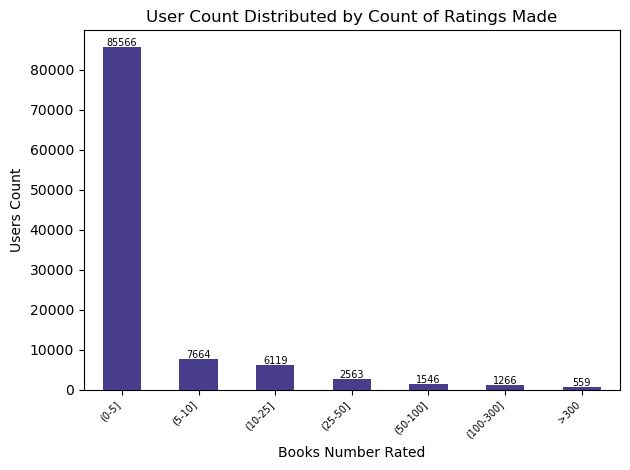

In [146]:
ax=users_count_binned.plot.bar(color='darkslateblue')
ax.set_title("User Count Distributed by Count of Ratings Made")
ax.set_xlabel("Books Number Rated")
ax.set_ylabel("Users Count")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=7)
# Display values per each of the bars
for p in ax.patches:
    # find a value for a bar
    ax.annotate(p.get_height(), 
                 # calculate the position of text
                 (p.get_x() + p.get_width() / 2., p.get_height()+1000), 
                 ha = 'center', va = 'center', fontsize=7)
plt.tight_layout()
fig = ax.get_figure()
fig.savefig("Output/Binning_User.png")

### Bin data by users count, who rated a book

In [132]:
# check distribution by number of users, who gave rates for a book
groupped_r_books=ratings_df.groupby('ISBN')['User-ID'].count().sort_values()
groupped_r_books=pd.DataFrame(groupped_r_books).reset_index().rename(columns={'User-ID':'count_of_users_rated'})
groupped_r_books

,ISBN,count_of_users_rated
0,0688009328,1
1,0817221999,1
2,0817224181,1
3,0817230254,1
4,0817230300,1
...,...,...
340551,0312195516,723
340552,0060928336,732
340553,0385504209,883
340554,0316666343,1295


In [133]:
# split book-ratings count per book into bins to visualize and undertand the distribution
groupped_r_books=binning([0,5,10,25,50,100,300], groupped_r_books, 'count_of_users_rated', 'users_count_range')
groupped_r_books

,ISBN,count_of_users_rated,users_count_range
0,0688009328,1,(0-5]
1,0817221999,1,(0-5]
2,0817224181,1,(0-5]
3,0817230254,1,(0-5]
4,0817230300,1,(0-5]
...,...,...,...
340551,0312195516,723,>300
340552,0060928336,732,>300
340553,0385504209,883,>300
340554,0316666343,1295,>300


In [134]:
books_count_binned=groupped_r_books.groupby('users_count_range')['ISBN'].count().sort_values(ascending=False)
books_count_binned

users_count_range
(0-5]        305799
(5-10]        18595
(10-25]       10840
(25-50]        3197
(50-100]       1404
(100-300]       639
>300             82
Name: ISBN, dtype: int64

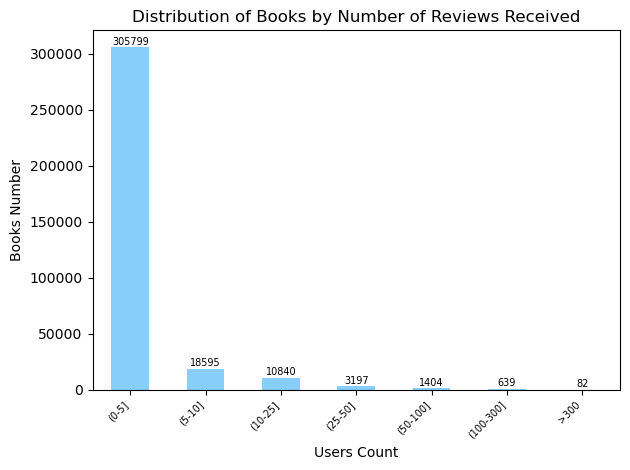

In [144]:
ax=books_count_binned.plot.bar(color=['lightskyblue'])
ax.set_title('Distribution of Books by Number of Reviews Received')
ax.set_xlabel("Users Count")
ax.set_ylabel("Books Number")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=7)
# Display values per each of the bars
for p in ax.patches:
    # find a value for a bar
    ax.annotate(p.get_height(), 
                 # calculate the position of text
                 (p.get_x() + p.get_width() / 2., p.get_height()+5000), 
                 ha = 'center', va = 'center', fontsize=7)
plt.tight_layout()
fig = ax.get_figure()
fig.savefig("Output/Binning_Books.png")

### Change ISBN with Titles
Merge ratings with books data in order to change isbn with title and leave only those ratings data for which we have title info

In [18]:
ratings_df=pd.merge(books_df,ratings_df,on='ISBN', how = 'inner')
ratings_df.head(2)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2,0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5


In [19]:
# delete those rows with no book titles or no book rates if any (even though there should no be such as we used inner join above)
ratings_df=ratings_df.dropna()
ratings_df_all_cols=ratings_df.copy()
# delete those columns, which we are not going to use within machine learning algos
ratings_df=ratings_df.drop(['ISBN','Book-Author','Year-Of-Publication','Publisher','Image-URL-S','Image-URL-M','Image-URL-L'], axis=1)
ratings_df.head(2)

,Book-Title,User-ID,Book-Rating
0,Classical Mythology,2,0
1,Clara Callan,8,5


In [20]:
# Filter out data with zero ratings
ratings_df_no_zeros = ratings_df[ratings_df['Book-Rating'] != 0]

In [21]:
# As an alternative to the above update 0 scores with weighted averages

In [22]:
# find average score per each book (only take non-zero into account)
avg_ratings_scored = ratings_df[ratings_df['Book-Rating'] > 0].groupby('Book-Title')['Book-Rating'].mean()
# count of non-zero rating given per book
count_ratings_scored = ratings_df[ratings_df['Book-Rating'] > 0].groupby('Book-Title')['Book-Rating'].count()
# create dataframe with above data (average and count) per book
average_weighted_df=pd.DataFrame(avg_ratings_scored).rename(columns={'Book-Rating':'avg_book_rating'})
count_ratings_scored_df=pd.DataFrame(count_ratings_scored).rename(columns={'Book-Rating':'count_book_rating'})
average_weighted_df=pd.merge(average_weighted_df,count_ratings_scored_df,  on='Book-Title', how='inner')
average_weighted_df=average_weighted_df.sort_values(by='count_book_rating', ascending=False)
# find average weighted per book
average_weighted_df['avg_weighted']=average_weighted_df.apply(average_weighted, axis=1)
# update zero rating values with average weighted
ratings_df_adj=ratings_df.copy()
ratings_df_adj.loc[ratings_df_adj['Book-Rating'] == 0, 'Book-Rating'] = ratings_df_adj.loc[ratings_df_adj['Book-Rating'] == 0].index.map(average_weighted_df['avg_weighted'])
# Filter out data with n/a rating score after mapping, as there could be books with only 0 scores
ratings_df_adj=ratings_df_adj.dropna(subset=['Book-Rating'])

In [23]:
# check if there are duplicated records when same user rated book(s) with same title several times
dupl_user_title=ratings_df_adj[ratings_df_adj.duplicated(subset=['Book-Title', 'User-ID'],keep=False)].sort_values(by=['Book-Title','User-ID'])
dupl_user_title.head(2)

,Book-Title,User-ID,Book-Rating
93704,1984,112083,9.0
237681,1984,112083,9.0


In [24]:
# Use avg rate per duplicates set for three: ratings_df, ratings_df_adj and ratings_df_no_zeros
ratings_df_original=ratings_df.groupby(['Book-Title','User-ID'])['Book-Rating'].mean().reset_index()
ratings_df_mean=ratings_df_adj.groupby(['Book-Title','User-ID'])['Book-Rating'].mean().reset_index()
ratings_df_no_zeros=ratings_df_no_zeros.groupby(['Book-Title','User-ID'])['Book-Rating'].mean().reset_index()
ratings_df_no_zeros.head(2)

,Book-Title,User-ID,Book-Rating
0,A Light in the Storm: The Civil War Diary of ...,96448,9.0
1,"Ask Lily (Young Women of Faith: Lily Series, ...",269557,8.0


In [25]:
# leave only statistically significant data for both ratings_df_adj and ratings_df_no_zeros
rating_final_original_df=leave_stat_sign_data(ratings_df_original)
rating_final_mean_df=leave_stat_sign_data(ratings_df_adj)
rating_final_no_zeros_df=leave_stat_sign_data(ratings_df_no_zeros)

# Pure SVD model

### Train/Test split

In [26]:
train_set_original, test_set_original = train_test_split_SVD(rating_final_original_df)
train_set_mean, test_set_mean = train_test_split_SVD(rating_final_mean_df)
train_set_no_zeros, test_set_no_zeros = train_test_split_SVD(rating_final_no_zeros_df)

##  Generation of a matrix with predicted rates per book

In [27]:
all_predictions_df_original=build_prediction_matrix_SVD(rating_final_original_df)
all_predictions_df_mean=build_prediction_matrix_SVD(rating_final_mean_df)
all_predictions_no_zeros=build_prediction_matrix_SVD(rating_final_no_zeros_df)

In [28]:
all_predictions_df_mean

Book-Title,"Earth Prayers From around the World: 365 Prayers, Poems, and Invocations for Honoring the Earth",!Yo!,'Salem's Lot,01-01-00: The Novel of the Millennium,10 Lb. Penalty,"10,000 dreams interpreted: A dictionary of dreams",100 Best-Loved Poems (Dover Thrift Editions),100 Selected Poems by E. E. Cummings,1001 Things Everyone Should Know About Science,1001 Ways to Be Romantic,...,"\O\"" Is for Outlaw""","\Surely You're Joking, Mr. Feynman!\"": Adventures of a Curious Character""","\The Happy Prince\"" and Other Stories (Penguin Popular Classics)""","\What Do You Care What Other People Think?\"": Further Adventures of a Curious Character""",e,iI Paradiso Degli Orchi,murder@maggody.com : An Arly Hanks Mystery (Arly Hanks Mysteries (Paperback)),one hundred years of solitude,stardust,why I'm like this : True Stories
User-ID,,,,,,,,,,,,,,,,,,,,,
8,0.000245,0.000219,0.000056,0.002000,-0.000336,0.000394,0.000052,0.000047,-0.000200,0.000140,...,-0.001038,0.001280,0.000396,0.000330,-0.000644,0.000353,0.000510,0.000039,0.002024,0.000403
99,0.002913,0.003248,0.001333,-0.001974,0.002214,-0.000002,0.004381,0.001519,0.005974,0.004444,...,-0.003512,0.003680,0.002735,0.002110,-0.006801,0.003581,0.006024,-0.000692,0.003367,0.005465
114,0.008808,0.000331,-0.035543,0.056729,-0.069261,-0.004213,-0.017281,-0.038169,-0.009262,-0.017620,...,0.026166,-0.008591,0.045725,0.002359,0.084810,0.001898,-0.011920,-0.037713,-0.021000,-0.015035
242,-0.008163,0.002806,0.098813,-0.010835,-0.032621,-0.001764,0.027848,0.026195,-0.014049,-0.000306,...,-0.094758,0.051785,-0.000270,-0.002696,-0.036294,0.000138,0.000584,0.000879,0.008610,-0.009145
243,-0.014596,0.012220,-0.086185,0.010529,-0.020236,0.017999,-0.026686,0.084581,0.043281,0.061944,...,0.477174,0.006837,-0.021648,-0.008918,-0.029811,-0.009990,0.006611,-0.012845,-0.077676,0.009178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278633,0.016941,0.003876,-0.037586,-0.017051,-0.066762,0.008461,-0.022465,0.025970,0.041588,0.060244,...,-0.240852,-0.059897,-0.012479,-0.003743,0.042439,0.004137,0.008666,0.017967,-0.154048,0.055585
278694,0.002407,0.002294,-0.002261,0.008578,0.001928,0.002335,0.000164,0.003819,0.003144,0.003134,...,0.047935,0.003106,0.002439,0.002280,0.001762,0.002784,0.001542,0.002566,0.005401,0.001730
278843,-0.011425,-0.027014,0.051353,-0.000474,0.025538,0.002019,-0.041905,0.053412,0.000979,0.002522,...,0.107071,0.039368,-0.010670,-0.004503,0.190347,0.002539,0.005742,0.106894,0.067311,-0.024405


## Testing Accuracy

In [29]:
rmse_scores_original = test_rmse_SVD(train_set_original, test_set_original)
rmse_scores_mean = test_rmse_SVD(train_set_mean, test_set_mean)
rmse_scores_no_zeros = test_rmse_SVD(train_set_no_zeros, test_set_no_zeros)
print('Accuracy for original data (number of latent factors, RMSE):')
display(rmse_scores_original)
print('Accuracy for data with no 0 ratings (number of latent factors, RMSE):')
display(rmse_scores_no_zeros)
print('Accuracy for data with weighted mean instead of 0 ratings (number of latent factors, RMSE):')
display(rmse_scores_mean)

Accuracy for original data (number of latent factors, RMSE):


{8: 4.398417279798325,
 20: 4.385653005159332,
 50: 4.375080113190378,
 100: 4.372465619481789,
 150: 4.3781818309086065}

Accuracy for data with no 0 ratings (number of latent factors, RMSE):


{8: 7.81046854689452,
 20: 7.7739527506547965,
 50: 7.74088900996351,
 100: 7.747020695731258,
 150: 7.768680395006911}

Accuracy for data with weighted mean instead of 0 ratings (number of latent factors, RMSE):


{8: 7.804385409014685,
 20: 7.763957334351544,
 50: 7.726863477383926,
 100: 7.726620976269654,
 150: 7.737858975605288}

# SVD Funk
Use of surprise module with built-in SVD algorithm (popularized by Simon Funk during the Netflix Prize):

class surprise.prediction_algorithms.matrix_factorization.SVD(n_factors=100, n_epochs=20, biased=True, init_mean=0, init_std_dev=0.1, lr_all=0.005, reg_all=0.02, lr_bu=None, lr_bi=None, lr_pu=None, lr_qi=None, reg_bu=None, reg_bi=None, reg_pu=None, reg_qi=None, random_state=None, verbose=False)

In [30]:
# receive data, in a format compatible with surprise module and split into train and test 
# two options considered here: input data are those without 0 ratings and those with weighted mean instead of 0 ratings
data_surprise_o_original, train_set_original, test_set_original =  data_prep_train_test_split_surpsise(rating_final_original_df)
data_surprise_o_no_zeros, train_set_no_zeros, test_set_no_zeros =  data_prep_train_test_split_surpsise(rating_final_no_zeros_df)
data_surprise_o_mean, train_set_mean, test_set_mean =  data_prep_train_test_split_surpsise(rating_final_mean_df)

# check train and test data for one of the options:
train_data_mean = list(train_set_mean.all_ratings())

display('------Train Set------')
print(f'Size of train_set: {len(train_data_mean)}')
print(f'Number of users in train_set: {train_set_mean.n_users}')
print(f'Number of books in train_set: {train_set_mean.n_items}')
display(f'Few elements of train_set (user, book, rating): {train_data_mean[:15]}')
display('------Test Set------')
print(f'Size of test_set: {len(test_set_mean)}')
display(f'Few elements of test_set (user, book, rating): {test_set_mean[:15]}')

'------Train Set------'

Size of train_set: 127351
Number of users in train_set: 10290
Number of books in train_set: 10648


'Few elements of train_set (user, book, rating): [(0, 0, 8.0), (0, 546, 7.0), (0, 1493, 6.0), (0, 4508, 6.0), (0, 3563, 7.0), (0, 316, 9.0), (0, 500, 8.0), (0, 586, 8.0), (0, 3471, 7.0), (0, 9434, 8.0), (0, 3648, 8.0), (0, 6406, 7.0), (0, 637, 7.0), (0, 9359, 7.0), (0, 563, 8.0)]'

'------Test Set------'

Size of test_set: 14151


'Few elements of test_set (user, book, rating): [(133868, \'Heartless\', 8.0), (39705, \'The Song Reader\', 9.0), (13850, \'Black Holes and Baby Universes and Other Essays\', 10.0), (126053, \'The Perks of Being a Wallflower\', 10.0), (221870, "Sullivan\'s Sting", 10.0), (204676, \'Brave New World\', 10.0), (257212, "The Girls\' Guide to Hunting and Fishing", 8.0), (265546, \'Midnight in the Garden of Good and Evil: A Savannah Story\', 8.0), (35859, \'Fahrenheit 451\', 10.0), (195904, \'MOONLIGHT BECOMES YOU\', 3.0), (91058, \'Key of Light (Key Trilogy (Paperback))\', 8.0), (265889, \'First Lady\', 5.0), (67782, \'My Hairiest Adventure (Goosebumps, No 26)\', 9.0), (77307, \'Atlas Shrugged\', 10.0), (241980, \'Monkeewrench\', 7.0)]'

###  Training: cross validate the model

In [31]:
print('Cross Validation for original data:')
cross_validation_surpsise_SVD_Funk(data_surprise_o_original)
print('Cross Validation for data with no 0 ratings:')
cross_validation_surpsise_SVD_Funk(data_surprise_o_no_zeros)
print('Cross Validation for data with weighted means instead of 0 ratings:')
cross_validation_surpsise_SVD_Funk(data_surprise_o_mean)

Cross Validation for original data:
RMSE: 3.5157
RMSE: 3.5101
RMSE: 3.5245
RMSE: 3.5093
RMSE: 3.5143


'Average Root Mean Square Error (RMSE) for SVD is 3.51'

Cross Validation for data with no 0 ratings:
RMSE: 1.5916
RMSE: 1.5684
RMSE: 1.5713
RMSE: 1.5748
RMSE: 1.5581


'Average Root Mean Square Error (RMSE) for SVD is 1.57'

Cross Validation for data with weighted means instead of 0 ratings:
RMSE: 1.5852
RMSE: 1.5674
RMSE: 1.5732
RMSE: 1.5742
RMSE: 1.5742


'Average Root Mean Square Error (RMSE) for SVD is 1.57'

### Training: identify best parameters¶

In [32]:
params_original=hypertuning_SVD_Funk(data_surprise_o_original)
params_no_zeros=hypertuning_SVD_Funk(data_surprise_o_no_zeros)
params_mean=hypertuning_SVD_Funk(data_surprise_o_mean)

Best parameters for original data:
Best parameters for data with no 0 ratings:
Best parameters for data with weighted means instead of 0 ratings:


{'n_factors': 10, 'n_epochs': 100, 'lr_all': 0.002, 'reg_all': 0.2}

In [37]:
print('Best parameters for original data:')
display(params_original)
print('Best parameters for data with no 0 ratings:')
display(params_no_zeros)
print('Best parameters for data with weighted means instead of 0 ratings:')
display(params_mean)

Best parameters for original data:


{'n_factors': 10, 'n_epochs': 30, 'lr_all': 0.002, 'reg_all': 0.2}

Best parameters for data with no 0 ratings:


{'n_factors': 10, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.1}

Best parameters for data with weighted means instead of 0 ratings:


{'n_factors': 10, 'n_epochs': 100, 'lr_all': 0.002, 'reg_all': 0.2}

### Training: Build models

In [33]:
# Build SVD with default parameters
svd_default= SVD()
# Build SVD, using hyperparameters recevied in the result of hypertuning
svd_best_parameters_original = SVD(n_factors=params_original['n_factors'], n_epochs=params_original['n_epochs'],lr_all=params_original['lr_all'], reg_all=params_original['reg_all'])
svd_best_parameters_mean = SVD(n_factors=params_mean['n_factors'], n_epochs=params_mean['n_epochs'],lr_all=params_mean['lr_all'], reg_all=params_mean['reg_all'])
svd_best_parameters_no_zeros = SVD(n_factors=params_no_zeros['n_factors'], n_epochs=params_no_zeros['n_epochs'],lr_all=params_no_zeros['lr_all'], reg_all=params_no_zeros['reg_all'])

### Training: Fit models

In [36]:
# Train the models on trainset
svd_best_parameters_model_original = svd_best_parameters_original.fit(train_set_original)
svd_best_parameters_model_no_zeros = svd_best_parameters_no_zeros.fit(train_set_no_zeros)
svd_best_parameters_model_mean = svd_best_parameters_mean.fit(train_set_mean)
svd_default_model_original = svd_default.fit(train_set_original)
svd_default_model_mean = svd_default.fit(train_set_mean)
svd_default_model_no_zeros = svd_default.fit(train_set_no_zeros)

## Recommendation generation

## Check Accuracy

In [58]:
# Check the accuracy for both default vs tuned method
accuracy_svd_funk_d={}
accuracy_svd_funk={}
accuracy_svd_funk['Original']=accuracy.rmse(svd_best_parameters_model_original.test(test_set_original), verbose=False)
accuracy_svd_funk['No_Zeros']=accuracy.rmse(svd_best_parameters_model_no_zeros.test(test_set_no_zeros), verbose=False)
accuracy_svd_funk['Mean']=accuracy.rmse(svd_best_parameters_model_mean.test(test_set_mean), verbose=False)
accuracy_svd_funk_d['Original']=accuracy.rmse(svd_default_model_original.test(test_set_original), verbose=False)
accuracy_svd_funk_d['No_Zeros']=accuracy.rmse(svd_default_model_no_zeros.test(test_set_no_zeros), verbose=False)
accuracy_svd_funk_d['Mean']=accuracy.rmse(svd_default_model_mean.test(test_set_mean), verbose=False)
                                                                    
print(f'''Accuracy, based on Root Mean Square Error, of a 
1. Tuned Model: 
 a. original data
 {accuracy_svd_funk['Original']} 
 b. data with no 0 ratings
 {accuracy_svd_funk['No_Zeros']} 
 c. data with weighted means instead of 0 ratings
 {accuracy_svd_funk['Mean']}
2. Model with Default Parameters:
 a. original data
 {accuracy_svd_funk_d['Original']} 
 b. data with no 0 ratings
 {accuracy_svd_funk_d['No_Zeros']} 
 c. data with weighted means instead of 0 ratings
 {accuracy_svd_funk_d['Mean']} 
''')

Accuracy, based on Root Mean Square Error, of a 
1. Tuned Model: 
 a. original data
 3.364866109795677 
 b. data with no 0 ratings
 1.5387216944677278 
 c. data with weighted means instead of 0 ratings
 1.5645760685461747
2. Model with Default Parameters:
 a. original data
 6.41159491305756 
 b. data with no 0 ratings
 1.5596534372915958 
 c. data with weighted means instead of 0 ratings
 1.052423710306215 



In [44]:
# import all the models
with open('svd_best_parameters_model_original.pickle', 'wb') as f:
    pickle.dump(svd_best_parameters_model_original, f)
with open('svd_best_parameters_model_no_zeros.pickle', 'wb') as f:
    pickle.dump(svd_best_parameters_model_no_zeros, f)
with open('svd_best_parameters_model_mean.pickle', 'wb') as f:
    pickle.dump(svd_best_parameters_model_mean, f)
with open('svd_default_model_original.pickle', 'wb') as f:
    pickle.dump(svd_default_model_original, f)
with open('svd_default_model_no_zeros.pickle', 'wb') as f:
    pickle.dump(svd_default_model_no_zeros, f)
with open('svd_default_model_mean.pickle', 'wb') as f:
    pickle.dump(svd_default_model_mean, f)

# to load svd_default_model_mean in flask use 
# with open('svd_default_model_mean.pickle', 'rb') as f:
#     svd_default_model_mean_l = pickle.load(f)
    

In [75]:
# compose accuracy per features number for SVD into a single dataframe
rmse_scores_svd_df = pd.DataFrame(list(rmse_scores_original.items()), columns=['Latent_Features_Number', 'Original']).set_index('Latent_Features_Number')
rmse_scores_svd_df['No_Zeros']=list(rmse_scores_no_zeros.values())
rmse_scores_svd_df['Mean']=list(rmse_scores_mean.values())
rmse_scores_svd_df

,Original,No_Zeros,Mean
Latent_Features_Number,,,
8,4.398417,7.810469,7.804385
20,4.385653,7.773953,7.763957
50,4.375080,7.740889,7.726863
100,4.372466,7.747021,7.726621
150,4.378182,7.768680,7.737859


In [86]:
# find min for each input data variation for the above df 
rmse_scores_min_svd={}
for i in rmse_scores_svd_df.columns:
    rmse_scores_min_svd[i]=rmse_scores_svd_df[i].min()
rmse_scores_min_svd

{'Original': 4.372465619481789,
 'No_Zeros': 7.74088900996351,
 'Mean': 7.726620976269654}

In [91]:
# compose accuracy data for all SVDs into a single dataframe
accuracy_svds_df = pd.DataFrame(columns=list(accuracy_svd_funk.keys()))
tuned=pd.DataFrame([accuracy_svd_funk], index=['Tuned SVD Funk'])
default=pd.DataFrame([accuracy_svd_funk_d], index=['SVD Funk Default Parameters'])
mf=pd.DataFrame([rmse_scores_min_svd], index=['SVD'])
accuracy_svds_df=pd.concat([accuracy_svd_funk_df, tuned])
accuracy_svds_df=pd.concat([accuracy_svd_funk_df, default])
accuracy_svds_df=pd.concat([accuracy_svd_funk_df, mf])
accuracy_svds_df

,Original,No_Zeros,Mean
Tuned SVD Funk,3.364866,1.538722,1.564576
SVD Funk Default Parameters,6.411595,1.559653,1.052424
SVD,4.372466,7.740889,7.726621


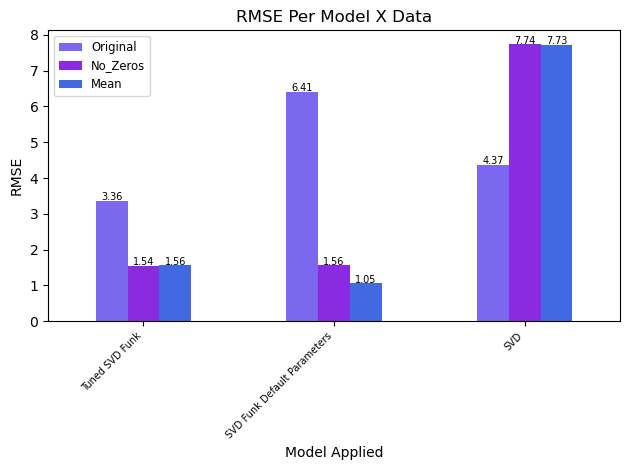

In [108]:
# build charts for models accuracy comparison
# compare models output errors for SVD models
ax1 = accuracy_svds_df.plot.bar(color=['mediumslateblue', 'blueviolet', 'royalblue'])
ax1.set_title("RMSE Per Model X Data")
ax1.set_xlabel("Model Applied")
ax1.set_ylabel("RMSE")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=7)
ax1.legend(fontsize='small')

# Display values per each of the bars
for p in ax1.patches:
    # find a value for a bar
    ax1.annotate(format(p.get_height(), '.2f'), 
                 # calculate the position of text
                 (p.get_x() + p.get_width() / 2., p.get_height()+0.1), 
                 ha = 'center', va = 'center', fontsize=7)

plt.tight_layout()
fig = ax1.get_figure()
fig.savefig("Output/SVD_Models_RMSE_Comparison.png")

/var/folders/3g/t4y_09d901v7s2qw9dqk8jzw0000gn/T/ipykernel_1303/3805732865.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=7)


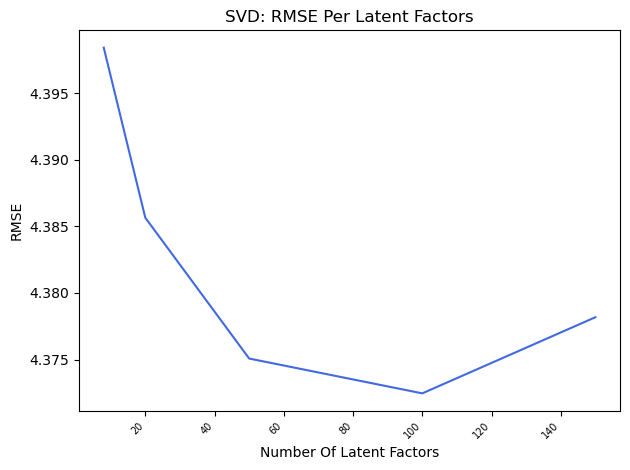

In [103]:
# compare models output errors for SVD
ax = rmse_scores_svd_df['Original'].plot(color=['royalblue'])
ax.set_title("SVD: RMSE Per Latent Factors")
ax.set_xlabel("Number Of Latent Factors")
ax.set_ylabel("RMSE")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=7)
plt.tight_layout()
fig = ax.get_figure()
fig.savefig("Output/SVD_Model_RMSE_Comparison.png")

# Check predictions for specific user

In [39]:
# find original user ratings
u_data=ratings_df_all_cols[ratings_df_all_cols['User-ID']==252676].sort_values(by='Book-Rating', ascending=False)
u_data[['User-ID','Book-Title','Book-Rating','Book-Author','Year-Of-Publication','Publisher']]

,User-ID,Book-Title,Book-Rating,Book-Author,Year-Of-Publication,Publisher
1016791,252676,The Twelve Days of Christmas,10,Anne Geddes,1997,Cedco Publishing Company
1016789,252676,"The Flavors of Bon Appetit 1997 (Bon Appetit ,...",8,Editors of Bon Appetit,1997,Pantheon Books
533707,252676,The Importance of Being Earnest: A Trivial Nov...,8,Charles Osborne,2000,St Martins Pr
1016788,252676,Lilith's Cave: Jewish Tales of the Supernatural,7,Howard Schwartz,1988,Harpercollins
83181,252676,The Brethren,7,John Grisham,2000,Island
957473,252676,The Devil's Cat,6,William W. Johnstone,1987,Zebra Books
182440,252676,Hideaway,5,Dean R. Koontz,1992,Berkley Publishing Group
42777,252676,Skipping Christmas,0,JOHN GRISHAM,2001,Doubleday
740036,252676,Vespers,0,Jeff Rovin,1999,St. Martin's Press
1016790,252676,"The Best of Gourmet 1997 (Best of Gourmet, 1997)",0,The Editors of Gourmet,1997,Random House Trade


In [40]:
# preview recommendations by pure SVD (mean)
recommend_books_for_user(252676, ratings_df, books_df, all_predictions=all_predictions_df_mean)

,Book-Title,estimated rate,ISBN,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,The Testament,0.565589,0440234743,John Grisham,1999,Dell,http://images.amazon.com/images/P/0440234743.0...,http://images.amazon.com/images/P/0440234743.0...,http://images.amazon.com/images/P/0440234743.0...
9,A Painted House,0.544247,0385337930,JOHN GRISHAM,2004,Delta,http://images.amazon.com/images/P/0385337930.0...,http://images.amazon.com/images/P/0385337930.0...,http://images.amazon.com/images/P/0385337930.0...
16,The Runaway Jury,0.439251,0375433449,JOHN GRISHAM,2003,Random House Large Print,http://images.amazon.com/images/P/0375433449.0...,http://images.amazon.com/images/P/0375433449.0...,http://images.amazon.com/images/P/0375433449.0...
22,Timeline,0.437515,3442451221,Michael Crichton,2002,Distribooks,http://images.amazon.com/images/P/3442451221.0...,http://images.amazon.com/images/P/3442451221.0...,http://images.amazon.com/images/P/3442451221.0...
25,The Partner,0.421584,0440224764,John Grisham,1998,Dell Publishing Company,http://images.amazon.com/images/P/0440224764.0...,http://images.amazon.com/images/P/0440224764.0...,http://images.amazon.com/images/P/0440224764.0...


In [41]:
# preview recommendations by Funk SVD, default (mean)
recommend_books_for_user(252676, ratings_df, books_df, model=svd_default_model_mean)

,Book-Title,Estimated_Rate,ISBN,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,Harry Potter and the Chamber of Secrets Postca...,9.121726,0439425220,J. K. Rowling,2002,Scholastic,http://images.amazon.com/images/P/0439425220.0...,http://images.amazon.com/images/P/0439425220.0...,http://images.amazon.com/images/P/0439425220.0...
1,Calvin and Hobbes,9.028364,0836220889,Bill Watterson,1987,Andrews McMeel Publishing,http://images.amazon.com/images/P/0836220889.0...,http://images.amazon.com/images/P/0836220889.0...,http://images.amazon.com/images/P/0836220889.0...
2,Dilbert: A Book of Postcards,8.902249,0836213319,Scott Adams,1996,Andrews McMeel Pub,http://images.amazon.com/images/P/0836213319.0...,http://images.amazon.com/images/P/0836213319.0...,http://images.amazon.com/images/P/0836213319.0...
3,Weirdos From Another Planet!,8.862800,0836218620,Bill Watterson,1990,Andrews McMeel Publishing,http://images.amazon.com/images/P/0836218620.0...,http://images.amazon.com/images/P/0836218620.0...,http://images.amazon.com/images/P/0836218620.0...
4,"My Sister's Keeper : A Novel (Picoult, Jodi)",8.846136,0743454529,Jodi Picoult,2004,Atria,http://images.amazon.com/images/P/0743454529.0...,http://images.amazon.com/images/P/0743454529.0...,http://images.amazon.com/images/P/0743454529.0...


In [42]:
# preview recommendations by Funk SVD, tuned (mean)
recommend_books_for_user(252676, ratings_df, books_df, model=svd_best_parameters_model_mean)

,Book-Title,Estimated_Rate,ISBN,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,Dilbert: A Book of Postcards,9.008638,0836213319,Scott Adams,1996,Andrews McMeel Pub,http://images.amazon.com/images/P/0836213319.0...,http://images.amazon.com/images/P/0836213319.0...,http://images.amazon.com/images/P/0836213319.0...
1,Harry Potter and the Chamber of Secrets Postca...,8.895190,0439425220,J. K. Rowling,2002,Scholastic,http://images.amazon.com/images/P/0439425220.0...,http://images.amazon.com/images/P/0439425220.0...,http://images.amazon.com/images/P/0439425220.0...
2,"My Sister's Keeper : A Novel (Picoult, Jodi)",8.844796,0743454529,Jodi Picoult,2004,Atria,http://images.amazon.com/images/P/0743454529.0...,http://images.amazon.com/images/P/0743454529.0...,http://images.amazon.com/images/P/0743454529.0...
3,Fox in Socks (I Can Read It All by Myself Begi...,8.705113,0394800389,Dr. Seuss,1965,Random House Children's Books,http://images.amazon.com/images/P/0394800389.0...,http://images.amazon.com/images/P/0394800389.0...,http://images.amazon.com/images/P/0394800389.0...
5,Where the Sidewalk Ends : Poems and Drawings,8.654336,0060256672,Shel Silverstein,1974,HarperCollins,http://images.amazon.com/images/P/0060256672.0...,http://images.amazon.com/images/P/0060256672.0...,http://images.amazon.com/images/P/0060256672.0...
